In [2]:
import os
import cv2
import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from PIL import Image
from pathlib import Path
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

2024-09-02 14:10:26.339549: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print(os.listdir("chest_xray/chest_xray/"))

['.DS_Store', 'test', 'train', 'val']


In [4]:
data_dir = Path("chest_xray/chest_xray/")
train_dir = data_dir/"train"
val_dir = data_dir/"val"
test_dir = data_dir/"test"

In [5]:
def load_train():
    normal_cases_dir = train_dir / "NORMAL"
    pneumonia_cases_dir = train_dir / "PNEUMONIA"
    normal_cases = normal_cases_dir.glob('*.jpeg')
    pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
    train_data = []
    train_label = []
    for img in normal_cases:
        train_data.append(img)
        train_label.append("NORMAL")
    for img in pneumonia_cases:
        train_data.append(img)
        train_label.append("PNEUMONIA")
    df=pd.DataFrame(train_data)
    df.columns=['images']
    df['labels'] = train_label
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [6]:
train_data=load_train()
train_data.shape

(5216, 2)

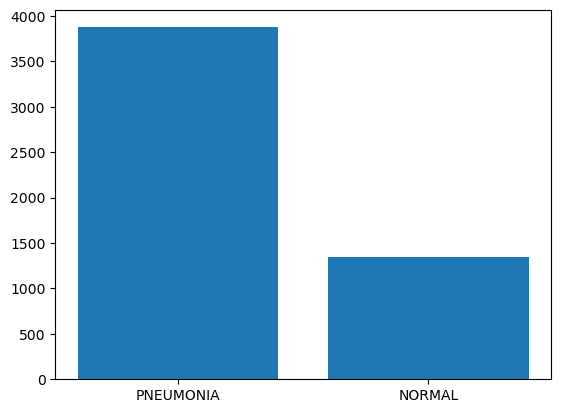

In [7]:
plt.bar(train_data['labels'].value_counts().index,train_data['labels'].value_counts().values)
plt.show()

In [8]:
def create_batches(df, batch_size=10):
    image_batch = df['images'][:batch_size].values
    label_batch = df['labels'][:batch_size].values
    return image_batch, label_batch

image_batch, label_batch = create_batches(train_data)

In [9]:
def plot(image_batch, label_batch):
    plt.figure(figsize =(10,5))
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        img = cv2.imread(str(image_batch[i]))
        img = cv2.resize(img, (224,224))
        plt.imshow(img)
        plt.title(label_batch[i])
        plt.axis("off")

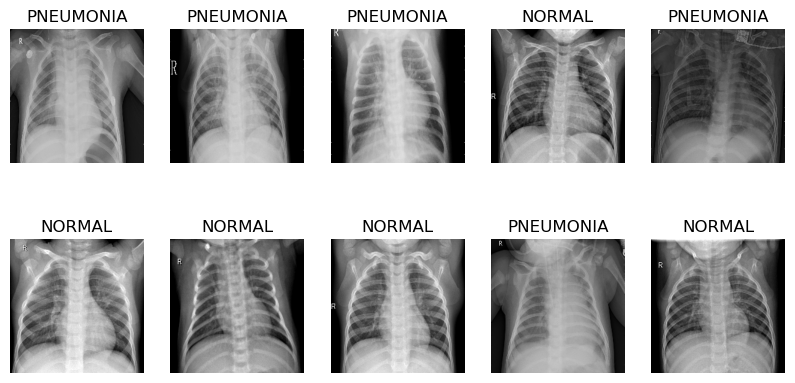

In [10]:
plot(image_batch,label_batch)

In [11]:
def prepare_and_load(isval= True):
    if isval == True:
        normal_dir = val_dir/'NORMAL'
        pneumonia_dir = val_dir/'PNEUMONIA'
    else:
        normal_dir = test_dir/'NOMRAL'
        pneumonia_dir = test_dir/'PNEUMONIA'
    normal_cases = normal_dir.glob('*.jpeg')
    pneumonia_cases = pneumonia_dir.glob('*.jpeg')
    data,labels =([] for x in range(2))
    def prepare(case):
        for img in case:
            img = cv2.imread(str(img))
            img = cv2.resize(img, (224,224))
            if img.shape[2] ==1:
                img = np.dstack([img,img,img])
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.
            if case==normal_cases:
                label = to_categorical(0,num_classes = 2)
            else:
                label = to_categorical(1,num_classes = 2)
            data.append(img)
            labels.append(label)
        return data,labels
    prepare(normal_cases)
    d,l = prepare(pneumonia_cases)
    d=np.array(d)
    l=np.array(l)
    return d,l

In [12]:
val_data,val_labels= prepare_and_load(isval = True)
test_data,test_labels= prepare_and_load(isval = False)
print("Number of test images is", len(test_data))
print("Number of validation images", len(val_data))

Number of test images is 390
Number of validation images 16


In [13]:
def data_gen(data, batch_size):
    n = len(data)
    steps = n // batch_size
    
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size, 2), dtype=np.float32)
    indices = np.arange(n)
    
    i = 0
    while True:
        np.random.shuffle(indices)
        count = 0
        next_batch = indices[(i * batch_size):(i + 1) * batch_size]  # Corrected variable name
        
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['images']
            label = data.iloc[idx]['labels']
            label = 0 if label == 'NORMAL' else 1
            
            encoded_label = to_categorical(label, num_classes=2)
            
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224, 224))  # Corrected resize function
            
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            orig_img = img.astype(np.float32) / 255.0
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            count += 1
            
            if count == batch_size:  # Corrected count check
                break
        
        i += 1
        yield batch_data, batch_labels
        
        if i >= steps:
            i = 0  # Reset to the beginning of the data for the next epoch


In [14]:
model = Sequential()
model.add(Conv2D(32,(3,3), input_shape = (224,224,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

/Users/maxomeara/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
batch_size = 16
nb_epochs = 3

train_data_gen = data_gen(data=train_data, batch_size = batch_size)

nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(val_data)))

Number of training and validation steps: 326 and 16


In [16]:
model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

history = model.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps, validation_data=(val_data, val_labels))

Epoch 1/3
326/326 ━━━━━━━━━━━━━━━━━━━━ 303s 924ms/step - accuracy: 0.7693 - loss: 0.5624 - val_accuracy: 0.8750 - val_loss: 0.4156
Epoch 2/3
326/326 ━━━━━━━━━━━━━━━━━━━━ 289s 886ms/step - accuracy: 0.9215 - loss: 0.4112 - val_accuracy: 0.7500 - val_loss: 0.4604
Epoch 3/3
326/326 ━━━━━━━━━━━━━━━━━━━━ 277s 849ms/step - accuracy: 0.9273 - loss: 0.4311 - val_accuracy: 0.7500 - val_loss: 0.4741


In [17]:
def vgg16_model(num_classes = None):
    model = VGG16(weights='imagenet', include_top = True, input_shape=(224,224,3))
    
    x = Dense(1024,activation = 'relu')(model.layers[-4].output)
    x = Dropout(0.7)(x)
    x = Dense(512,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(2,activation='softmax')(x)
    
    model = Model(model.input,x)
    
    return model

In [18]:
vgg_conv=vgg16_model(2)
for layer in vgg_conv.layers[:-10]:
    layer.trainable = False

In [19]:
from keras.optimizers import Adam

opt = Adam(learning_rate=0.0001, decay=1e-5)
vgg_conv.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)


/Users/maxomeara/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [20]:
history = vgg_conv.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps, validation_data=(val_data, val_labels))

Epoch 1/3
326/326 ━━━━━━━━━━━━━━━━━━━━ 2536s 8s/step - accuracy: 0.7261 - loss: 0.6300 - val_accuracy: 0.5000 - val_loss: 0.7361
Epoch 2/3
326/326 ━━━━━━━━━━━━━━━━━━━━ 2918s 9s/step - accuracy: 0.7322 - loss: 0.5893 - val_accuracy: 0.5000 - val_loss: 0.7678
Epoch 3/3
326/326 ━━━━━━━━━━━━━━━━━━━━ 2777s 9s/step - accuracy: 0.7459 - loss: 0.5672 - val_accuracy: 0.5000 - val_loss: 0.9004


In [21]:
loss,acc=vgg_conv.evaluate(test_data,test_labels,batch_size=16)
print("Loss = ", loss, "& Accuracy", acc)

25/25 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 1.0000 - loss: 0.2115
Loss =  0.21434816718101501 & Accuracy 1.0


In [24]:
pred = vgg_conv.predict(test_data, batch_size=16)
pred = np.argmax(pred, axis=-1)

labels = np.argmax(test_labels, axis=-1)
from sklearn.metrics import classification_report

print(classification_report(labels, pred))


25/25 ━━━━━━━━━━━━━━━━━━━━ 155s 6s/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       390

    accuracy                           1.00       390
   macro avg       1.00      1.00      1.00       390
weighted avg       1.00      1.00      1.00       390



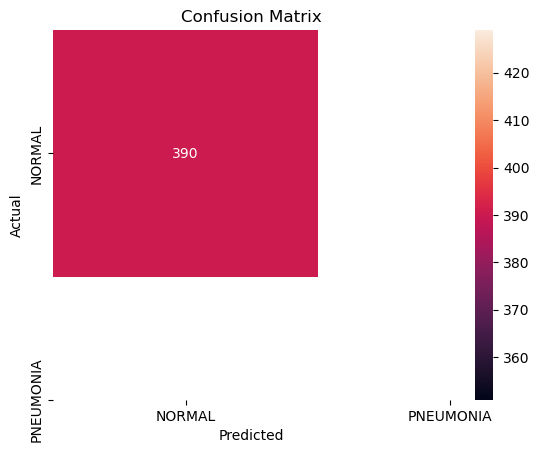

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, pred)
sns.heatmap(cm, annot=True, fmt='g', xticklabels=['NORMAL', "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
